In [2]:
# =========================================
# 🔒 Phishing Detector — Real-Time Features
# =========================================

import os, pickle, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Load dataset
CSV_PATH = "data/kaggle_phishing_dataset.csv"
df = pd.read_csv(CSV_PATH)

# 2) Select only features we can extract in real-time
selected_features = [
    "NumDots", "NumDash", "UrlLength", "AtSymbol", "NumUnderscore",
    "NumPercent", "NumQueryComponents", "NumAmpersand", "NumHash",
    "NumNumericChars", "NoHttps", "IpAddress", "HostnameLength",
    "PathLength", "QueryLength", "DoubleSlashInPath",
    "IframeOrFrame", "PopUpWindow", "RightClickDisabled", "ExtFormAction"
]

X = df[selected_features].copy()
y = df["CLASS_LABEL"].copy()  # 1=phishing, 0=legit

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4) Train model
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 5) Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 6) Save model + features
os.makedirs("models", exist_ok=True)
with open("models/content_model_rt.pkl", "wb") as f:
    pickle.dump(model, f)

import json
with open("models/feature_names_rt.json", "w") as f:
    json.dump(selected_features, f, indent=2)

print("✅ Model and features saved for real-time detection")


✅ Accuracy: 0.885

Classification Report:
               precision    recall  f1-score   support

           0     0.9019    0.8640    0.8825      1000
           1     0.8695    0.9060    0.8874      1000

    accuracy                         0.8850      2000
   macro avg     0.8857    0.8850    0.8849      2000
weighted avg     0.8857    0.8850    0.8849      2000

Confusion Matrix:
 [[864 136]
 [ 94 906]]
✅ Model and features saved for real-time detection


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

# Load dataset
CSV_PATH = "data/kaggle_phishing_dataset.csv"
df = pd.read_csv(CSV_PATH)

# Load trained model (real-time feature model)
with open("models/content_model_rt.pkl", "rb") as f:
    model = pickle.load(f)

# Load feature names
with open("models/feature_names_rt.json", "r") as f:
    FEATURE_NAMES = json.load(f)

# Prepare features and labels
X = df[FEATURE_NAMES]
y = df['CLASS_LABEL']

# For model evaluation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


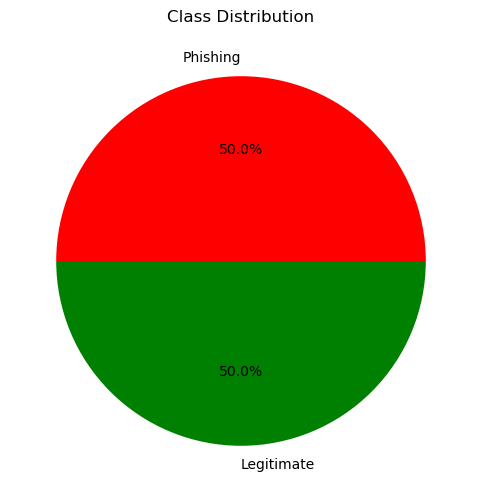

In [32]:
class_counts = df['CLASS_LABEL'].value_counts()
labels = ['Phishing', 'Legitimate']

plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=['red','green'])
plt.title('Class Distribution')
plt.show()


C:\Users\gaura\AppData\Local\Temp\ipykernel_12136\3596133071.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette="viridis")


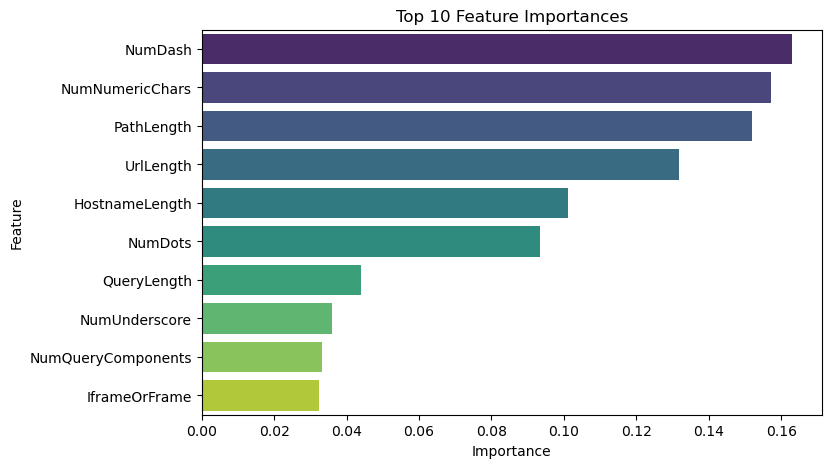

In [25]:
# Feature importance from trained Random Forest
feature_importances = pd.Series(model.feature_importances_, index=FEATURE_NAMES).sort_values(ascending=False)

# Top 10 features
top_features = feature_importances.head(10).reset_index()
top_features.columns = ['Feature', 'Importance']

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=top_features, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.show()


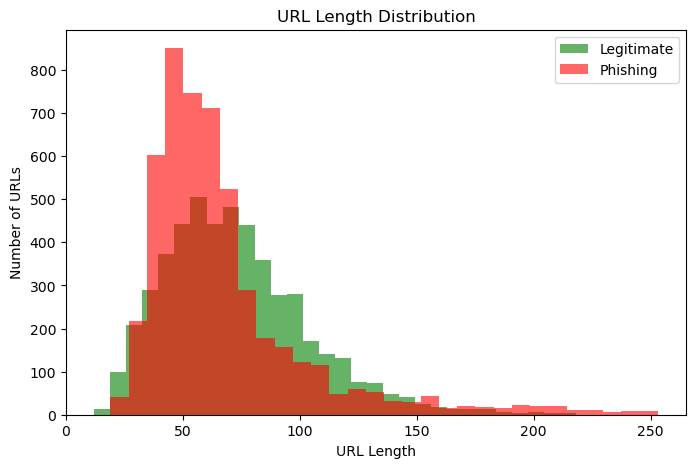

In [26]:
plt.figure(figsize=(8,5))
plt.hist(df[df['CLASS_LABEL']==0]['UrlLength'], bins=30, alpha=0.6, label='Legitimate', color='green')
plt.hist(df[df['CLASS_LABEL']==1]['UrlLength'], bins=30, alpha=0.6, label='Phishing', color='red')
plt.title("URL Length Distribution")
plt.xlabel("URL Length")
plt.ylabel("Number of URLs")
plt.legend()
plt.show()


C:\Users\gaura\AppData\Local\Temp\ipykernel_12136\4079505360.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CLASS_LABEL', y='NumDots', data=df, palette=['green','red'])


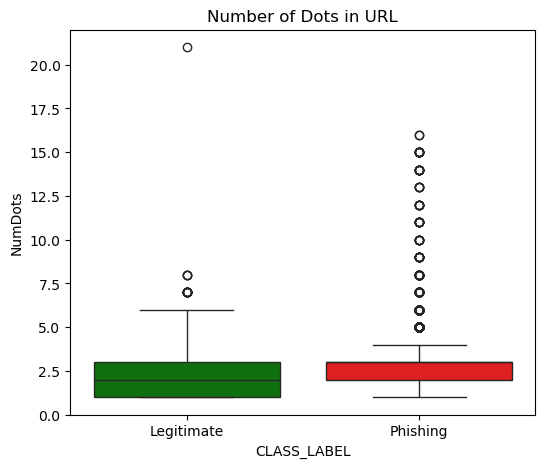

In [27]:
plt.figure(figsize=(6,5))
sns.boxplot(x='CLASS_LABEL', y='NumDots', data=df, palette=['green','red'])
plt.xticks([0,1], ['Legitimate', 'Phishing'])
plt.title("Number of Dots in URL")
plt.show()


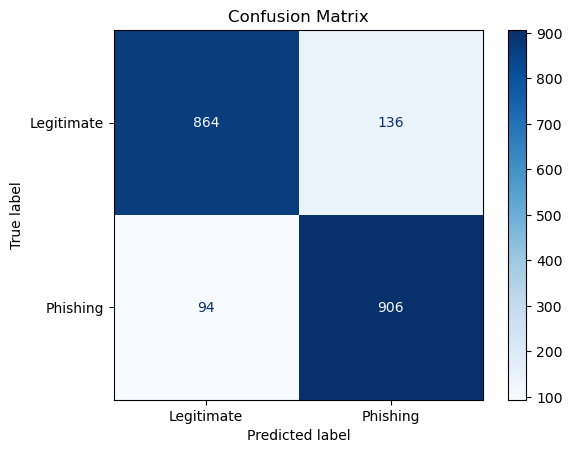

In [28]:
# Predictions on test set
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate','Phishing'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


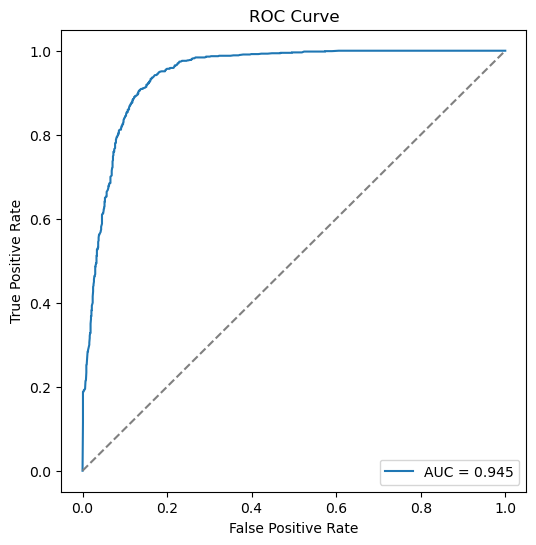

In [29]:
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


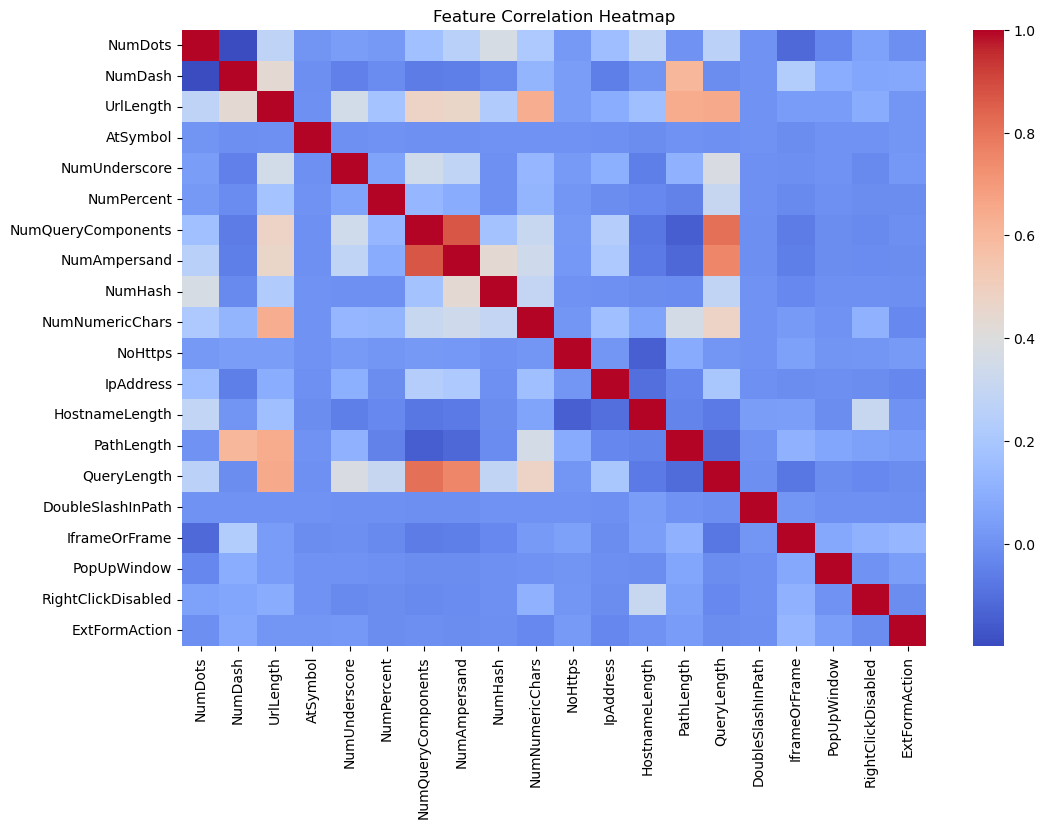

In [30]:
plt.figure(figsize=(12,8))
sns.heatmap(df[FEATURE_NAMES].corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [3]:
df["CLASS_LABEL"].value_counts()


CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64

In [4]:
df[["UrlLength", "NumDots", "NumDash", "CLASS_LABEL"]].head(10)


,UrlLength,NumDots,NumDash,CLASS_LABEL
0,72,3,0,1
1,144,3,0,1
2,58,3,0,1
3,79,3,1,1
4,46,3,0,1
5,42,3,1,1
6,60,2,0,1
7,30,1,0,1
8,76,8,1,1
9,46,2,0,1


In [5]:
import pandas as pd
import numpy as np

importances = model.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feat_importance.head(10))


NumDash               0.163049
NumNumericChars       0.157121
PathLength            0.151888
UrlLength             0.131741
HostnameLength        0.101038
NumDots               0.093420
QueryLength           0.043831
NumUnderscore         0.036021
NumQueryComponents    0.033284
IframeOrFrame         0.032482
dtype: float64
